# Red neuronal LSTM para predecir niveles del río Orinoco

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras import Sequential, layers

In [137]:
data = pd.read_csv("data/dataset_combinado.csv")
data.head()

,fecha,ayacucho,caicara,ciudad_bolivar,palua
0,1974/01/01,43.34,24.98,6.89,3.83
1,1974/01/02,43.25,24.88,6.78,3.93
2,1974/01/03,43.14,24.78,6.73,3.75
3,1974/01/04,43.04,24.68,6.68,3.49
4,1974/01/05,42.94,24.58,6.62,3.64


In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18683 entries, 0 to 18682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fecha           18683 non-null  object 
 1   ayacucho        17983 non-null  float64
 2   caicara         18683 non-null  float64
 3   ciudad_bolivar  18683 non-null  float64
 4   palua           18666 non-null  float64
dtypes: float64(4), object(1)
memory usage: 729.9+ KB


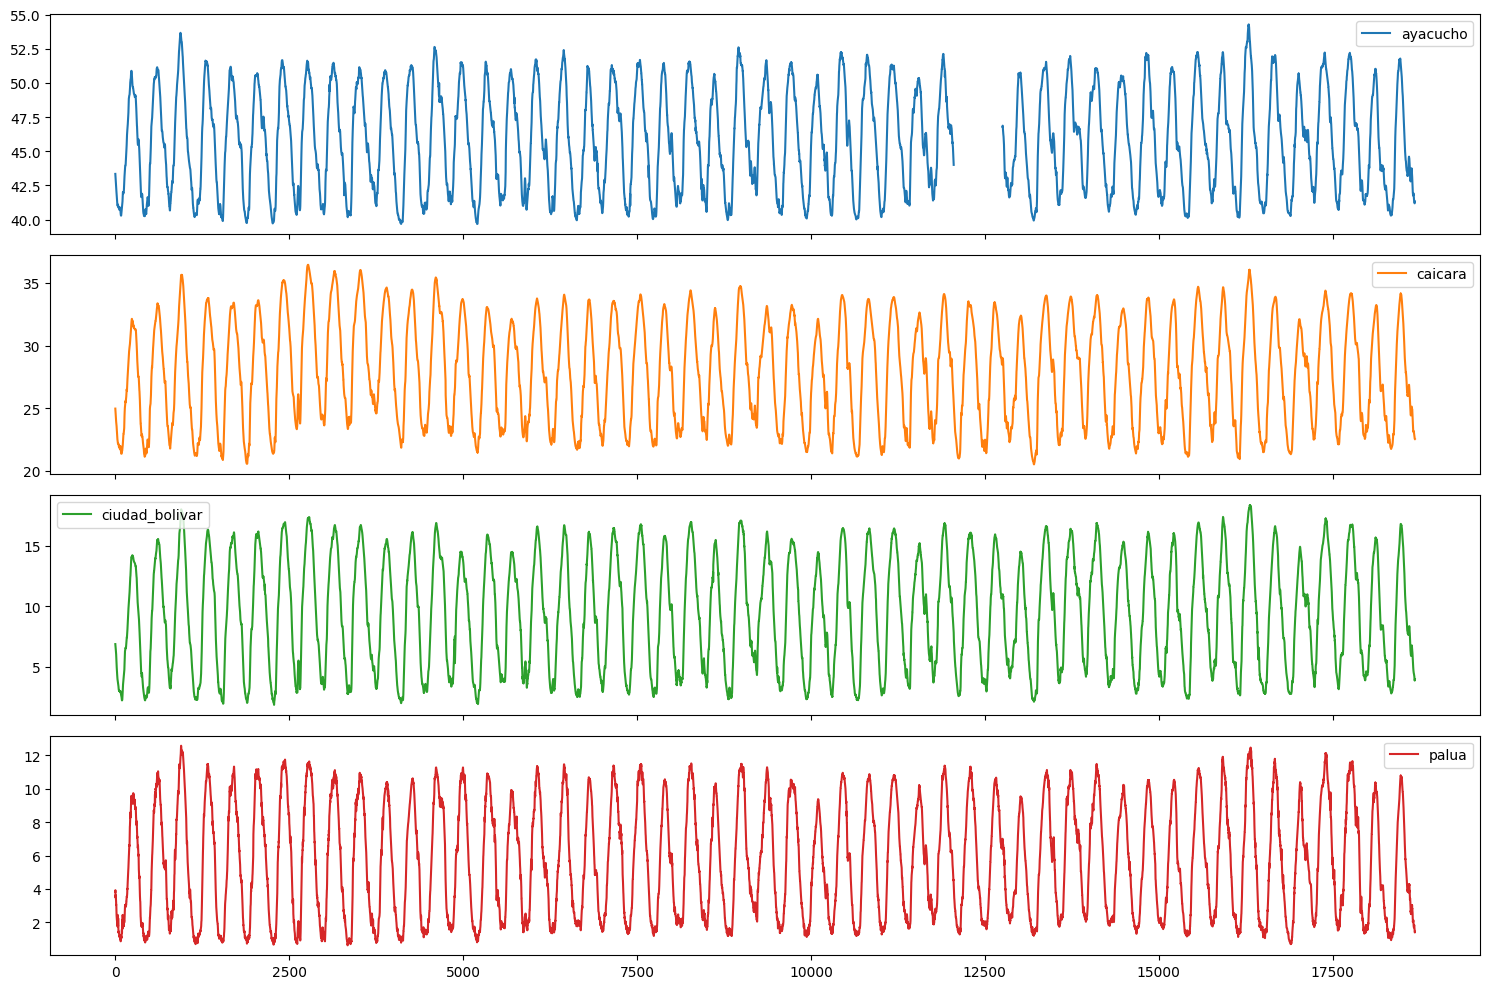

In [139]:
# Graficar valores de cada columna
data[['ayacucho', 'caicara', 'ciudad_bolivar', 'palua']].plot(subplots=True, figsize=(15, 10))
plt.tight_layout()

In [140]:
# Eliminar registros con valores nulos
data.dropna(inplace=True)

In [141]:
# Normalizar las nuevas características
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[[
    'ayacucho',
    'caicara',
    'ciudad_bolivar',
    'palua',
]])

In [163]:
# Crear secuencias para predecir múltiples días futuros
sequence_length = 90  # Ventana de entrada
forecast_steps = 10   # Número de días futuros a predecir
batch_size = 16

In [164]:
# Elegir índice de corte para training y testing (por ejemplo 80% para training)
split_index = int(len(data_scaled) * 0.8)

# Asegurarse de que haya suficientes datos para generar secuencias
if split_index < sequence_length + forecast_steps:
    raise ValueError("El conjunto de datos es demasiado pequeño para generar las secuencias requeridas.")

train_data = data_scaled[:split_index]
test_data = data_scaled[split_index:]

In [165]:
def split_sequences(sequences, n_steps_in: int, n_steps_out: int):
    """
    Divide una secuencia multivariada en muestras de entrada y salida

    Usado para problemas donde se reciben múltiples secuencias, y
    se desea predecir el siguiente valor de cada una

    Tomado de
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    """
    X, y = list(), list()
    for i in range(len(sequences)):
		# find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [166]:
train_X, train_y = split_sequences(train_data, sequence_length, forecast_steps)
test_X, test_y = split_sequences(test_data, sequence_length, forecast_steps)

# Visualizar
print(train_X[0], train_y[0])

[[0.25068493 0.27952261 0.30437424 0.26778243]
 [0.24452055 0.27324121 0.29769137 0.27615063]
 [0.2369863  0.2669598  0.29465371 0.26108787]
 [0.23013699 0.26067839 0.29161604 0.23933054]
 [0.22328767 0.25439698 0.28797084 0.25188285]
 [0.21575342 0.25125628 0.28493317 0.25104603]
 [0.21027397 0.24811558 0.2818955  0.24853556]
 [0.20547945 0.24183417 0.27946537 0.23682008]
 [0.20273973 0.23555276 0.2709599  0.23430962]
 [0.19520548 0.22927136 0.2673147  0.23012552]
 [0.19041096 0.22298995 0.2636695  0.22677824]
 [0.18630137 0.21670854 0.2600243  0.21589958]
 [0.18150685 0.21356784 0.2527339  0.20585774]
 [0.1760274  0.21042714 0.24301337 0.20251046]
 [0.17123288 0.20728643 0.23693803 0.20334728]
 [0.16780822 0.20414573 0.2272175  0.18242678]
 [0.16164384 0.20100503 0.2162819  0.1665272 ]
 [0.15616438 0.19786432 0.20777643 0.15230126]
 [0.15068493 0.19158291 0.20048603 0.15062762]
 [0.14520548 0.18530151 0.19441069 0.14225941]
 [0.14041096 0.1790201  0.18833536 0.13556485]
 [0.13493151 

In [171]:
n_features = train_X.shape[2] # Número de características

# Ajustar el modelo para predecir forecast_steps valores futuros
model = Sequential([
    layers.LSTM(units=100, activation='relu', input_shape=(sequence_length, n_features)),
    layers.Dropout(0.2),
    layers.RepeatVector(forecast_steps),
    layers.LSTM(units=100, activation='relu', return_sequences=True),
    layers.Dropout(0.2),
    layers.TimeDistributed(layers.Dense(n_features)),
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\orinoco_lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [172]:
# Entrenar el modelo con más épocas
history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    epochs=5,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.0271 - mean_absolute_error: 0.1033 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 2/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 0.0033 - mean_absolute_error: 0.0427 - val_loss: 9.1967e-04 - val_mean_absolute_error: 0.0229
Epoch 3/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - loss: 0.0023 - mean_absolute_error: 0.0365 - val_loss: 0.0010 - val_mean_absolute_error: 0.0245
Epoch 4/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - loss: 0.0019 - mean_absolute_error: 0.0336 - val_loss: 7.7369e-04 - val_mean_absolute_error: 0.0209
Epoch 5/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - loss: 0.0017 - mean_absolute_error: 0.0319 - val_loss: 7.7398e-04 - val_mean_absolute_error: 0.0212


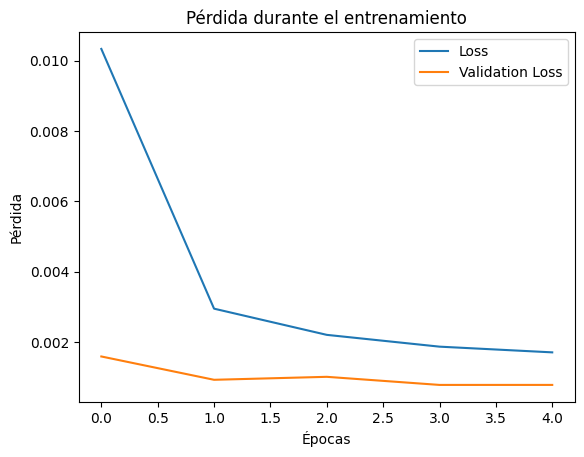

In [173]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Predicciones (10 días x 4 ciudades):
[[41.3321    22.812729   3.7573543  1.7614762]
 [41.205082  22.644156   3.5898204  1.6967199]
 [41.179646  22.606766   3.5374053  1.6708621]
 [41.189697  22.615488   3.534519   1.6665736]
 [41.201397  22.628124   3.5379748  1.6648918]
 [41.209873  22.638187   3.5411575  1.6634007]
 [41.215084  22.644894   3.5431292  1.6620017]
 [41.21765   22.648962   3.5440507  1.6606778]
 [41.218338  22.651133   3.5442147  1.6594504]
 [41.217804  22.652033   3.5438929  1.6583396]]
Valores reales (si están disponibles):
[[44.4  26.5   7.84  3.85]
 [44.48 26.6   7.96  3.89]
 [44.54 26.7   8.07  3.94]
 [44.58 26.8   8.06  3.94]
 [44.6  26.87  8.2   4.1 ]
 [44.57 26.88  8.28  4.3 ]
 [44.55 26.82  8.35  4.27]
 [44.52 26.78  8.37  4.27]
 [44.5  26.68  8.37  4.21]
 [44.45 26.6   8.34  4.27]]


<Figure size 1000x600 with 0 Axes>

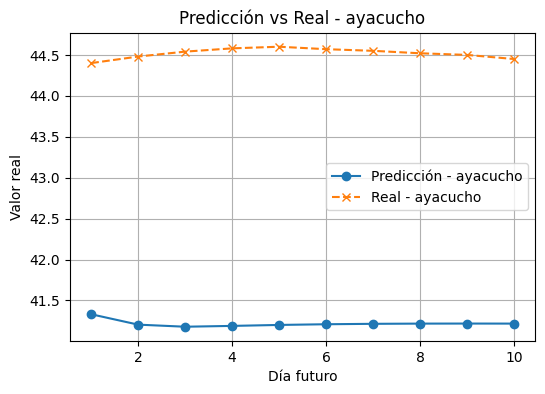

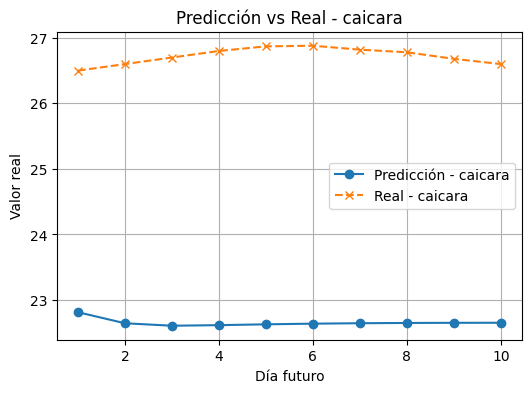

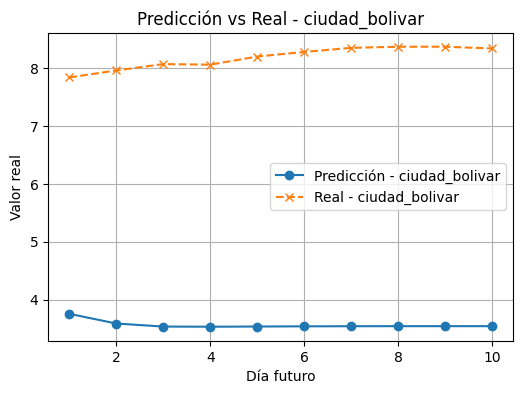

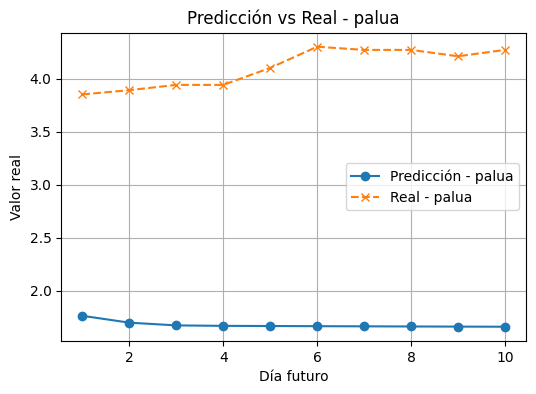

In [174]:
# Tomar la última secuencia del set de test para predecir los próximos 10 días
last_sequence = test_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, test_data.shape[1]))

# Predecir los próximos 10 días para las 4 ciudades
future_pred = model.predict(last_sequence)  # shape: (1, 10, 4)
future_pred = future_pred[0]  # shape: (10, 4)

# Desnormalizar la salida para obtener los valores reales
future_pred_real = scaler.inverse_transform(future_pred)

# Obtener los valores reales correspondientes (si están disponibles)
try:
    real_future = scaler.inverse_transform(test_data[-sequence_length: -sequence_length + forecast_steps, :4])
except Exception:
    real_future = None

print("Predicciones (10 días x 4 ciudades):")
print(future_pred_real)
print("Valores reales (si están disponibles):")
print(real_future)

# Graficar
ciudades = ['ayacucho', 'caicara', 'ciudad_bolivar', 'palua']
dias = np.arange(1, forecast_steps + 1)

plt.figure(figsize=(10, 6))
for i, ciudad in enumerate(ciudades):
    plt.figure(figsize=(6, 4))
    plt.plot(dias, future_pred_real[:, i], marker='o', label=f'Predicción - {ciudad}')
    if real_future is not None and real_future.shape == (forecast_steps, 4):
        plt.plot(dias, real_future[:, i], marker='x', linestyle='--', label=f'Real - {ciudad}')
    plt.xlabel('Día futuro')
    plt.ylabel('Valor real')
    plt.title(f'Predicción vs Real - {ciudad}')
    plt.legend()
    plt.grid()
    plt.show()